# Analyzing Cricket Player Statistics


First, let's import some modules. Use pip if you need to install any of these modules.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

We need to specify what format of cricket we want the statistics for. 

In [23]:
format = 1

format_name = ""
if format == 1:
    format_name = "Tests"
elif format == 2:
    format_name = "ODIs"
else:
    format_name = "T20s"

Now, here is where the magic happens.
We need to specify a player name (feel free to change the name), then the ESPN webpage is queried using the requests library.

In [24]:
player = 'Virat Kohli'
url = "http://search.espncricinfo.com/ci/content/player/search.html?search=" + player.lower().replace(" ","+") + "&x=0&y=0"
page = requests.get(url)

Inside this page, we get access to the url that leads to a player's home page. However, all we need is the player id, which is part of the hyperlink.

Thus, we use the BeautifulSoap library to find the hyperlink and do some text cleaning to get the player-id out of that hyperlink. 
Once we get the player-id, we can just query a player's stats once again using requests library. This time we send the webpage to pandas to find all the tables and choose the right one that has all the stats.

In [25]:
soup = BeautifulSoup(page.content, "html.parser")
player_id = str(soup.find_all(class_='ColumnistSmry')[0]).split('.html')[0].split('/')[-1]
df = pd.read_html(f'https://stats.espncricinfo.com/ci/engine/player/{player_id}.html?class={format};template=results;type=batting;view=innings')[3]

Just a sneak peak at the data. Feel free to explore it further!

In [26]:
df.head()

,Runs,Mins,BF,4s,6s,SR,Pos,Dismissal,Inns,Unnamed: 9,Opposition,Ground,Start Date,Unnamed: 13
0,4,13,10,1,0,40.00,5,caught,1,NaN,v West Indies,Kingston,20 Jun 2011,Test # 1997
1,15,72,54,2,0,27.77,5,caught,3,NaN,v West Indies,Kingston,20 Jun 2011,Test # 1997
2,0,1,2,0,0,0.00,5,caught,1,NaN,v West Indies,Bridgetown,28 Jun 2011,Test # 1998
3,27,118,107,1,1,25.23,5,caught,3,NaN,v West Indies,Bridgetown,28 Jun 2011,Test # 1998
4,30,62,53,2,0,56.60,5,caught,2,NaN,v West Indies,Roseau,6 Jul 2011,Test # 1999


Here is where the bulk of our analysis comes in. We iterate through the runs category and keep track of batting average as well as number of centuries scored.

In [11]:
runs = []
notout = []
innings = 0
batting_avg = []
hundreds = []
for i in df.Runs:
    if i != 'DNB' and i != 'TDNB' and i != 'sub':
        if '*' not in i:
            innings += 1
            notout.append(False)
        else:
            notout.append(True)
        runs.append(int(i.replace('*','')))
        if innings != 0:
            batting_avg.append(sum(runs)/innings)
        else:
            batting_avg.append(0)
        if len(hundreds) == 0:
            if runs[0] > 100:
                hundreds.append(1)
            else:
                hundreds.append(0)

        if runs[len(runs)-1]>=100 and len(hundreds)>0:
            hundreds.append(hundreds[len(hundreds)-1]+1)
        elif len(hundreds)>0:
            hundreds.append(hundreds[len(hundreds)-1])
    else:
        if len(runs) == 0:
            batting_avg.append(0)
            hundreds.append(0)
        else:
            batting_avg.append(batting_avg[len(batting_avg)-1])
            hundreds.append(hundreds[len(hundreds)-1])

df['batting_avg'] = pd.Series(batting_avg)
df['hundreds'] = pd.Series(hundreds)

We plot the results we found using matplotlib!

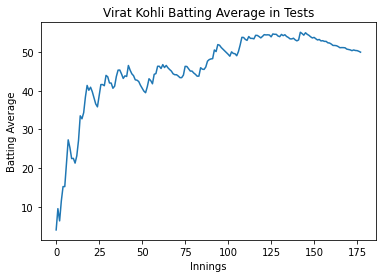

In [12]:
plt.title(f'{player} Batting Average in {format_name}')
plt.xlabel('Innings')
plt.ylabel('Batting Average')
plt.plot(df['batting_avg'])
plt.show()

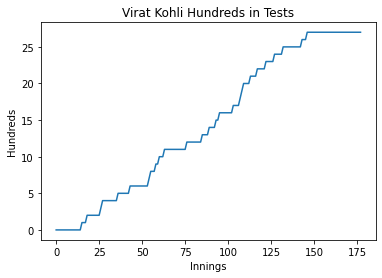

In [13]:
plt.title(f'{player} Hundreds in {format_name}')
plt.xlabel('Innings')
plt.ylabel('Hundreds')
plt.plot(df['hundreds'])
plt.show()

Now, we just bundle up everything we did above into a single function so we can reuse it.

In [15]:
def stats(player, form):
        url = "http://search.espncricinfo.com/ci/content/player/search.html?search=" + player.lower().replace(" ","+") + "&x=0&y=0"
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        player_id = str(soup.find_all(class_='ColumnistSmry')[0]).split('.html')[0].split('/')[-1]
        df = pd.read_html(f'https://stats.espncricinfo.com/ci/engine/player/{player_id}.html?class={form};template=results;type=batting;view=innings')[3]
        runs = []
        notout = []
        innings = 0
        batting_avg = []
        hundreds = []
        
        for i in df.Runs:
            if i != 'DNB' and i != 'TDNB' and i != 'sub':
                if '*' not in i:
                    innings += 1
                    notout.append(False)
                else:
                    notout.append(True)
                runs.append(int(i.replace('*','')))
                batting_avg.append(sum(runs)/innings)
                if len(hundreds) == 0:
                    if runs[0] > 100:
                        hundreds.append(1)
                    else:
                        hundreds.append(0)
        
                if runs[len(runs)-1]>=100 and len(hundreds)>0:
                    hundreds.append(hundreds[len(hundreds)-1]+1)
                elif len(hundreds)>0:
                    hundreds.append(hundreds[len(hundreds)-1])
            else:
                runs.append(0)
                if len(runs) == 0:
                    batting_avg.append(0)
                    hundreds.append(0)
                else:
                    batting_avg.append(batting_avg[len(batting_avg)-1])
                    hundreds.append(hundreds[len(hundreds)-1])
        
        
        
        df['batting_avg'] = pd.Series(batting_avg)
        df['hundreds'] = pd.Series(hundreds)
        df['runs'] = pd.Series(runs)
        
        return df


In [18]:
df = stats('Steven Smith', 1)
df2 = stats('Marnus Labuschagne', 1)


Now we can compare players!

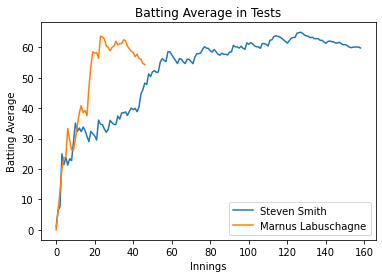

In [21]:
plt.title(f'Batting Average in {format_name}')
plt.xlabel('Innings')
plt.ylabel('Batting Average')
plt.plot(df['batting_avg'])
plt.plot(df2['batting_avg'])
plt.legend(['Steven Smith', 'Marnus Labuschagne'])
plt.show()